In [1]:
# Imports
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN,DCRNN,GConvGRU

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import torch.nn.functional as F
from pathlib import Path
import pathlib
import numpy as np
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric_temporal.nn.recurrent import AGCRN


In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:",device)

True
Device is: cuda


In [ ]:
# traffic_dataset = torch.load('./data/graph_data/1_hr_time_window_dynamic_graph/dataset_all_route_dynamic_graph_7_features.pt')
# traffic_dataset = torch.load('./data/graph_data/1_hr_time_window_dynamic_graph/dataset_all_route_dynamic_graph.pt')
# traffic_dataset = torch.load('./data/graph_data/1_hr_time_window_static_graph/dataset_all_route_single_graph.pt')
traffic_dataset = torch.load('../SNA_create_graph/data/graph_data/1_hr_time_window_static_graph/dataset_all_route_single_graph_all_features.pt')

In [ ]:
# # Removing graphs that just have zero bin in the graph to reduce sparsity
# cleaned_traffic_dataset = []

# for dataset in traffic_dataset:
#     y_list = np.array(dataset.y)
#     non_zero = np.count_nonzero(y_list)
#     if(non_zero == 0):
#         continue
#     else:
#         cleaned_traffic_dataset.append(dataset)

# traffic_dataset = cleaned_traffic_dataset

In [ ]:
len(traffic_dataset)

13525

In [ ]:
traffic_dataset[0].y.shape[0]

836

In [ ]:
for data in traffic_dataset:
    if data.y.shape[0] != 757:
        print(data)
        break

Data(edge_index=[2, 25], edge_attr=[25, 7], num_nodes=836, x=[836, 10], y=[836])


In [ ]:



Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]


class DynamicGraphTemporalSignal_custom(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            return torch.LongTensor(self.targets[time_index])
            # if self.targets[time_index].dtype.kind == "i":
            #     return torch.LongTensor(self.targets[time_index])
            # elif self.targets[time_index].dtype.kind == "f":
            #     return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
class myNewOwnLoader(object):
    """A dataset of county level chicken pox cases in Hungary between 2004
    and 2014. We made it public during the development of PyTorch Geometric
    Temporal. The underlying graph is static - vertices are counties and
    edges are neighbourhoods. Vertex features are lagged weekly counts of the
    chickenpox cases (we included 4 lags). The target is the weekly number of
    cases for the upcoming week (signed integers). Our dataset consist of more
    than 500 snapshots (weeks).
    """

    def __init__(self, dataset):
        # self._read_web_data()
        self._get_dataset(dataset)

    def _get_dataset(self,dataset):
        self._dataset = dataset

    def _get_edges(self):
        # self._edges = np.array(self._dataset["edges"]).T
        # ei = []
        # for data in self._dataset:
        #     ei.append(data.edge_index)
        e = []
        for data in self._dataset:
            e.append(data.edge_index)

        self._edges = e


    def _get_edge_weights(self):
        # self._edge_weights = np.ones(self._edges.shape[1])
        # ew = []
        # for data in self._dataset:
        #     ew.append(data.edge_attr)
        ew = []
        for data in self._dataset:
            ew.append(data.edge_attr[:, 0])
            # ew.append(data.edge_attr)


        self._edge_weights = ew

        # self._edge_weights = np.array(self._dataset[0].edge_attr)
        # self._edge_weights = self._dataset.edge_attr

    def _get_targets(self):

        y_class = []
        for data in self._dataset:
            y_class.append(data.y)

        self.targets = y_class
        # self.targets = self._dataset.y

    def _get_features(self):
        f = []
        for data in self._dataset:
            f.append(data.x)

        self.features = f
        # self.features = self._dataset.x

    def get_dataset(self, lags: int = 8) -> DynamicGraphTemporalSignal_custom:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets()
        self._get_features()
        # self._get_targets_and_features()
        # self.

        dataset = DynamicGraphTemporalSignal_custom(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [ ]:
test_size = int(len(traffic_dataset)*0.2)
val_size = int(len(traffic_dataset)*0.1)
train_size = len(traffic_dataset) - test_size - val_size

train_dataset = traffic_dataset[:train_size]
validation_dataset = traffic_dataset[train_size+1:train_size+val_size]
test_dataset = traffic_dataset[train_size+val_size+1:train_size+val_size+test_size]

print(len(train_dataset), len(validation_dataset), len(test_dataset))


9468 1351 2704


In [ ]:
def get_class_counts(dataset):
    y_train = []

    for dataset in dataset:
        y_train += list(np.array(dataset.y))

    y_train = np.array(y_train)
    class_counts = np.bincount(y_train)
    return class_counts, len(y_train)

train_count, total_train = get_class_counts(train_dataset)
val_count, total_val = get_class_counts(validation_dataset)
test_count, total_test = get_class_counts(test_dataset)

# Getting the percentage of bins to see how the distribution looks like
print(train_count*100/total_train)
print(val_count*100/total_val)
print(test_count*100/total_test)
# I can say its pretty similar but very very sparse

[ 9.96151984  5.56528361  0.68250546  0.18249586 83.60819522]
[14.42171137  8.12529439  1.31348744  0.43074597 75.70876083]
[13.15532898  7.36765133  1.30101427  0.37774093 77.79826449]


In [ ]:
newloader_train = myNewOwnLoader(train_dataset)
train_dataset = newloader_train.get_dataset(lags=8)

newloader_val = myNewOwnLoader(validation_dataset)
validation_dataset = newloader_val.get_dataset(lags=8)

newloader_test = myNewOwnLoader(test_dataset)
test_dataset = newloader_test.get_dataset(lags=8)

In [ ]:
train_dataset[0], validation_dataset[0], test_dataset[0]

(Data(x=[836, 10], edge_index=[2, 25], edge_attr=[25], y=[836]),
 Data(x=[836, 10], edge_index=[2, 179], edge_attr=[179], y=[836]),
 Data(x=[836, 10], edge_index=[2, 103], edge_attr=[103], y=[836]))

In [ ]:
train_dataset[0].edge_attr

torch.Size([25])

In [ ]:
y_train = []

for dataset in train_dataset:
    y_train += list(np.array(dataset.y))
    # y_train.append(np.array(dataset.y))



In [ ]:
y_train = np.array(y_train)

class_counts = np.bincount(y_train)
num_classes = 4
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

In [ ]:
class_counts, class_weights

# array([158929,  86989,  21581,   8111])

(array([ 788479,  440506,   54022,   14445, 6617796]),
 [10.038628803049923,
  17.9685361833891,
  146.5189737514346,
  547.9576323987538,
  1.1960550007887822])

In [ ]:

def train_one_epoch(train_loader, e):
    model.train()

    # Initial parameters
    cost = 0
    h = None
    count = 0 
    correct = 0
    for time, snapshot in enumerate(train_loader):
        snapshot.to(device)
        # x = snapshot.x.view(1, no_of_nodes, no_of_node_features)
        # y_hat, h = model(x, e, h)
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

        # Getting the focal loss
        cost = cost + focal_loss(y_hat.squeeze(), snapshot.y.long())
        pred = y_hat.argmax(dim=1)  # Use the class with highest probability.
        yp = np.array(pred.cpu()).flatten()
        yt = np.array(snapshot.y.cpu()).flatten()
        # Find the indices where yt is equal to 4
        indices_to_remove = np.where(yt == 4)
        yp = np.delete(yp, indices_to_remove)
        yt = np.delete(yt, indices_to_remove)
        correct += int((yp == yt).sum()) 
        count += len(yt)
    cost = cost / (time+1) #Getting the mean loss
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    accuracy = correct / count

    return accuracy, cost

def validate_one_epoch(validation_loader, e):
    model.eval()

    # Initial parameters
    cost = 0
    h = None
    count = 0 
    correct = 0
    for time, snapshot in enumerate(validation_loader):
        snapshot.to(device)
        # x = snapshot.x.view(1, no_of_nodes, no_of_node_features)
        # y_hat, h = model(x, e, h)
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

        # Getting the focal loss
        cost = cost + focal_loss(y_hat.squeeze(), snapshot.y.long())
        pred = y_hat.argmax(dim=1)  # Use the class with highest probability.
        yp = np.array(pred.cpu()).flatten()
        yt = np.array(snapshot.y.cpu()).flatten()
        # Find the indices where yt is equal to 4
        indices_to_remove = np.where(yt == 4)
        yp = np.delete(yp, indices_to_remove)
        yt = np.delete(yt, indices_to_remove)

        correct += int((yp == yt).sum()) 
        count += len(yt)
    cost = cost / (time+1) #Getting the mean loss
    
    accuracy = correct / count
    return accuracy, cost


In [ ]:


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss
    
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):

        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# Data(x=[45, 10], edge_index=[2, 94], edge_attr=[94, 7], y=[45])

In [ ]:
# no_of_nodes = 45
no_of_node_features = 10
num_classes = 5
lr = 0.01
edge_features = 1

EPOCHS = 400
patience = 150
early_stopper = EarlyStopper(patience=patience, min_delta=0)

# class RecurrentGCN(torch.nn.Module):
#     def __init__(self, node_features, num_classes):
#         super(RecurrentGCN, self).__init__()
#         self.transform = torch.nn.Linear(node_features,32)

#         self.recurrent = GConvGRU(in_channels = 32,
#                               out_channels = 32,K=3)
        
#         self.linear1 = torch.nn.Linear(node_features, 32)


#         # Future work add some MLP layers, increase out channels - to 64.in the future
#         self.mlp = torch.nn.Sequential(
#             torch.nn.Linear(32+node_features, 32),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.5),
#             torch.nn.Linear(32, 16),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.5),
#             torch.nn.Linear(16,num_classes)
#         )
#         # torch.nn.Linear(node_features, 32)
#         # self.linear2 = torch.nn.Linear(32+node_features, 32)
#         # self.linear = torch.nn.Linear(32, num_classes)


#     def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        
#         x = self.transform(x)
#         # Learning the edge attributes using MLP layer before sending in so it can be of dimension (no_of_features X 1)
#         input_feat = x.clone()
#         prev_hidden_state = self.recurrent(x, edge_index, edge_weight, prev_hidden_state).relu()
#         # prev_hidden_state = F.relu(prev_hidden_state)
        
#         h = F.relu(self.linear1(prev_hidden_state))
#         h = F.dropout(h,0.5)

#         combined = torch.cat((input_feat,h),dim = 1)

#         h = self.mlp(combined)

#         # h = F.relu(self.linear2(combined))
#         # h = self.linear(h)
        
#         h = F.log_softmax(h,dim=-1)
#         return h, prev_hidden_state

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, num_classes):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(in_channels = node_features,
                              out_channels = node_features,K=3)
        # Future work add some MLP layers, increase out channels - to 64.in the future
        self.linear1 = torch.nn.Linear(node_features, 32)
        self.linear2 = torch.nn.Linear(32, 16)
        self.linear = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)

        h = F.relu(self.linear1(h))
        h = F.relu(self.linear2(h))
        h = self.linear(h)
        h = F.log_softmax(h,dim=-1)
        return h
        
model = RecurrentGCN(node_features = no_of_node_features, num_classes=num_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:
class_weights = torch.FloatTensor(class_weights).to(device)
focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='FocalLoss',
	alpha=class_weights,
	gamma=2,
	reduction='mean',
	force_reload=False
).to(device)

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [ ]:

model_checkpoint_path = './model_checkpoint/GConvGRU/'
pathlib.Path(model_checkpoint_path).mkdir(parents=True, exist_ok=True) 

e = None
# e = torch.empty(no_of_nodes, 4)
# torch.nn.init.xavier_uniform_(e)

history = {
    'epoch':[],
    'train_acc':[],
    'validation_acc':[],
    'train_loss':[],
    'validation_loss':[]
}

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train_one_epoch(train_dataset, e)
    validation_acc, validation_loss = validate_one_epoch(validation_dataset, e)
    # print(validation_loss)
    PATH  = f'{model_checkpoint_path}/model_GConvGRU_{epoch}_static_graph.pt'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'validation_loss': validation_loss,
            }, PATH)
    
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {validation_acc:.4f}, Val Loss: {validation_loss:.4f}')

    history['epoch'].append(epoch+1)
    history['train_acc'].append(train_acc)
    history['validation_acc'].append(validation_acc)
    history['train_loss'].append(float(train_loss.data))
    history['validation_loss'].append(float(validation_loss.data))
    
    if early_stopper.early_stop(validation_loss):     
        print(f"Stopping early! {validation_loss}, {epoch}")      
        break


  0%|          | 1/400 [01:20<8:52:15, 80.04s/it]

Epoch: 000, Train Acc: 0.3395, Train Loss: 5.2579, Val Acc: 0.3345, Val Loss: 8.3950
Epoch: 001, Train Acc: 0.3395, Train Loss: 5.1720, Val Acc: 0.3345, Val Loss: 8.2684


  0%|          | 2/400 [02:39<8:49:06, 79.76s/it]

Epoch: 002, Train Acc: 0.3395, Train Loss: 5.1026, Val Acc: 0.3345, Val Loss: 8.1348


  1%|          | 3/400 [03:59<8:48:58, 79.94s/it]

Epoch: 003, Train Acc: 0.3395, Train Loss: 5.0296, Val Acc: 0.3345, Val Loss: 7.9629


  1%|          | 4/400 [05:44<9:53:22, 89.91s/it]

Epoch: 004, Train Acc: 0.3395, Train Loss: 4.9394, Val Acc: 0.3904, Val Loss: 7.7338


  1%|▏         | 5/400 [07:50<11:16:22, 102.74s/it]

Epoch: 005, Train Acc: 0.4205, Train Loss: 4.8275, Val Acc: 0.4199, Val Loss: 7.4742


  2%|▏         | 6/400 [09:18<10:40:59, 97.61s/it] 

Epoch: 006, Train Acc: 0.3751, Train Loss: 4.7083, Val Acc: 0.3238, Val Loss: 7.2186


  2%|▏         | 7/400 [10:38<10:02:01, 91.91s/it]

Epoch: 007, Train Acc: 0.2472, Train Loss: 4.6065, Val Acc: 0.2491, Val Loss: 6.9856


  2%|▏         | 8/400 [11:58<9:35:50, 88.14s/it] 

Epoch: 008, Train Acc: 0.1832, Train Loss: 4.5099, Val Acc: 0.2206, Val Loss: 6.7994


  2%|▏         | 9/400 [13:19<9:19:24, 85.84s/it]

Epoch: 009, Train Acc: 0.1572, Train Loss: 4.4341, Val Acc: 0.2065, Val Loss: 6.6574


  2%|▎         | 10/400 [14:41<9:10:27, 84.69s/it]

Epoch: 010, Train Acc: 0.1458, Train Loss: 4.3613, Val Acc: 0.2190, Val Loss: 6.5831


  3%|▎         | 11/400 [16:03<9:03:51, 83.89s/it]

Epoch: 011, Train Acc: 0.1580, Train Loss: 4.2925, Val Acc: 0.2225, Val Loss: 6.5761


  3%|▎         | 13/400 [18:44<8:49:25, 82.08s/it]

Epoch: 012, Train Acc: 0.2035, Train Loss: 4.2305, Val Acc: 0.3434, Val Loss: 6.6016


  4%|▎         | 14/400 [20:05<8:46:03, 81.77s/it]

Epoch: 013, Train Acc: 0.3662, Train Loss: 4.1779, Val Acc: 0.4919, Val Loss: 6.6198


  4%|▍         | 15/400 [21:25<8:42:02, 81.36s/it]

Epoch: 014, Train Acc: 0.4941, Train Loss: 4.1428, Val Acc: 0.3670, Val Loss: 6.6346


  4%|▍         | 16/400 [22:46<8:38:52, 81.07s/it]

Epoch: 015, Train Acc: 0.3650, Train Loss: 4.1377, Val Acc: 0.3345, Val Loss: 6.6057
Epoch: 016, Train Acc: 0.3395, Train Loss: 4.1278, Val Acc: 0.3662, Val Loss: 6.5115


  4%|▍         | 17/400 [24:06<8:36:16, 80.88s/it]

Epoch: 017, Train Acc: 0.3640, Train Loss: 4.0915, Val Acc: 0.3426, Val Loss: 6.3953


  4%|▍         | 18/400 [25:29<8:38:19, 81.41s/it]

Epoch: 018, Train Acc: 0.3335, Train Loss: 4.0450, Val Acc: 0.4230, Val Loss: 6.3234


  5%|▍         | 19/400 [26:51<8:38:20, 81.63s/it]

Epoch: 019, Train Acc: 0.4145, Train Loss: 4.0180, Val Acc: 0.3889, Val Loss: 6.3064


  5%|▌         | 20/400 [28:13<8:37:46, 81.75s/it]

Epoch: 020, Train Acc: 0.3885, Train Loss: 4.0163, Val Acc: 0.3066, Val Loss: 6.2964


  5%|▌         | 21/400 [29:35<8:36:58, 81.84s/it]

Epoch: 021, Train Acc: 0.2982, Train Loss: 4.0097, Val Acc: 0.3178, Val Loss: 6.2643


  6%|▌         | 22/400 [30:57<8:36:05, 81.92s/it]

Epoch: 022, Train Acc: 0.3061, Train Loss: 3.9767, Val Acc: 0.4008, Val Loss: 6.2344


  6%|▌         | 24/400 [33:38<8:27:56, 81.05s/it]

Epoch: 023, Train Acc: 0.3847, Train Loss: 3.9356, Val Acc: 0.3615, Val Loss: 6.2512


  6%|▋         | 25/400 [35:00<8:27:53, 81.26s/it]

Epoch: 024, Train Acc: 0.3463, Train Loss: 3.9156, Val Acc: 0.3770, Val Loss: 6.2902


  6%|▋         | 26/400 [36:21<8:27:46, 81.46s/it]

Epoch: 025, Train Acc: 0.3585, Train Loss: 3.9100, Val Acc: 0.3872, Val Loss: 6.2927


  7%|▋         | 27/400 [37:42<8:23:51, 81.05s/it]

Epoch: 026, Train Acc: 0.3727, Train Loss: 3.8933, Val Acc: 0.3949, Val Loss: 6.2403
Epoch: 027, Train Acc: 0.3828, Train Loss: 3.8623, Val Acc: 0.3399, Val Loss: 6.1643


  7%|▋         | 28/400 [39:02<8:21:02, 80.81s/it]

Epoch: 028, Train Acc: 0.3117, Train Loss: 3.8341, Val Acc: 0.3169, Val Loss: 6.1080


  7%|▋         | 29/400 [40:22<8:18:51, 80.68s/it]

Epoch: 029, Train Acc: 0.2813, Train Loss: 3.8202, Val Acc: 0.3565, Val Loss: 6.0720


  8%|▊         | 30/400 [41:42<8:16:13, 80.47s/it]

Epoch: 030, Train Acc: 0.3293, Train Loss: 3.8096, Val Acc: 0.3531, Val Loss: 6.0440


  8%|▊         | 31/400 [43:02<8:13:46, 80.29s/it]

Epoch: 031, Train Acc: 0.3268, Train Loss: 3.7890, Val Acc: 0.3111, Val Loss: 6.0335


  8%|▊         | 33/400 [45:42<8:09:26, 80.02s/it]

Epoch: 032, Train Acc: 0.2739, Train Loss: 3.7613, Val Acc: 0.3377, Val Loss: 6.0528


  8%|▊         | 34/400 [47:03<8:11:17, 80.54s/it]

Epoch: 033, Train Acc: 0.3099, Train Loss: 3.7403, Val Acc: 0.3741, Val Loss: 6.0784


  9%|▉         | 35/400 [48:26<8:12:58, 81.04s/it]

Epoch: 034, Train Acc: 0.3600, Train Loss: 3.7286, Val Acc: 0.3878, Val Loss: 6.0654
Epoch: 035, Train Acc: 0.3753, Train Loss: 3.7137, Val Acc: 0.3537, Val Loss: 6.0078


  9%|▉         | 36/400 [49:48<8:14:18, 81.48s/it]

Epoch: 036, Train Acc: 0.3333, Train Loss: 3.6909, Val Acc: 0.3342, Val Loss: 5.9435


  9%|▉         | 37/400 [51:11<8:14:54, 81.80s/it]

Epoch: 037, Train Acc: 0.3071, Train Loss: 3.6688, Val Acc: 0.3051, Val Loss: 5.9034


 10%|▉         | 38/400 [52:33<8:14:21, 81.94s/it]

Epoch: 038, Train Acc: 0.2695, Train Loss: 3.6528, Val Acc: 0.3091, Val Loss: 5.8798


 10%|▉         | 39/400 [53:55<8:13:14, 81.98s/it]

Epoch: 039, Train Acc: 0.2723, Train Loss: 3.6388, Val Acc: 0.3094, Val Loss: 5.8598


 10%|█         | 40/400 [55:17<8:11:41, 81.95s/it]

Epoch: 040, Train Acc: 0.2726, Train Loss: 3.6210, Val Acc: 0.3120, Val Loss: 5.8454


 10%|█         | 41/400 [56:38<8:08:03, 81.57s/it]

Epoch: 041, Train Acc: 0.2780, Train Loss: 3.5997, Val Acc: 0.3485, Val Loss: 5.8415


 10%|█         | 42/400 [57:58<8:04:03, 81.13s/it]

Epoch: 042, Train Acc: 0.3286, Train Loss: 3.5820, Val Acc: 0.3554, Val Loss: 5.8319


 11%|█         | 43/400 [59:19<8:03:53, 81.33s/it]

Epoch: 043, Train Acc: 0.3383, Train Loss: 3.5684, Val Acc: 0.3558, Val Loss: 5.8099


 11%|█         | 44/400 [1:00:39<7:59:57, 80.89s/it]

Epoch: 044, Train Acc: 0.3398, Train Loss: 3.5526, Val Acc: 0.3536, Val Loss: 5.7817


 11%|█▏        | 45/400 [1:02:01<8:00:41, 81.24s/it]

Epoch: 045, Train Acc: 0.3394, Train Loss: 3.5340, Val Acc: 0.3494, Val Loss: 5.7461


 12%|█▏        | 46/400 [1:03:24<8:01:05, 81.54s/it]

Epoch: 046, Train Acc: 0.3361, Train Loss: 3.5174, Val Acc: 0.3399, Val Loss: 5.7106


 12%|█▏        | 47/400 [1:04:45<8:00:18, 81.64s/it]

Epoch: 047, Train Acc: 0.3229, Train Loss: 3.5040, Val Acc: 0.3447, Val Loss: 5.6902


 12%|█▏        | 48/400 [1:06:08<8:00:01, 81.82s/it]

Epoch: 048, Train Acc: 0.3313, Train Loss: 3.4900, Val Acc: 0.3501, Val Loss: 5.6769


 12%|█▏        | 49/400 [1:07:30<7:59:43, 82.00s/it]

Epoch: 049, Train Acc: 0.3383, Train Loss: 3.4745, Val Acc: 0.3633, Val Loss: 5.6716


 12%|█▎        | 50/400 [1:08:52<7:58:41, 82.06s/it]

Epoch: 050, Train Acc: 0.3558, Train Loss: 3.4599, Val Acc: 0.3685, Val Loss: 5.6708


 13%|█▎        | 51/400 [1:10:15<7:58:39, 82.29s/it]

Epoch: 051, Train Acc: 0.3641, Train Loss: 3.4474, Val Acc: 0.3664, Val Loss: 5.6526


 13%|█▎        | 52/400 [1:11:38<7:58:18, 82.47s/it]

Epoch: 052, Train Acc: 0.3661, Train Loss: 3.4349, Val Acc: 0.3644, Val Loss: 5.6230


 13%|█▎        | 53/400 [1:13:00<7:56:06, 82.32s/it]

Epoch: 053, Train Acc: 0.3669, Train Loss: 3.4208, Val Acc: 0.3642, Val Loss: 5.5928


 14%|█▎        | 54/400 [1:14:23<7:55:29, 82.46s/it]

Epoch: 054, Train Acc: 0.3679, Train Loss: 3.4066, Val Acc: 0.3573, Val Loss: 5.5655


 14%|█▍        | 55/400 [1:15:45<7:54:23, 82.50s/it]

Epoch: 055, Train Acc: 0.3590, Train Loss: 3.3938, Val Acc: 0.3550, Val Loss: 5.5466


 14%|█▍        | 56/400 [1:17:07<7:51:01, 82.15s/it]

Epoch: 056, Train Acc: 0.3569, Train Loss: 3.3815, Val Acc: 0.3537, Val Loss: 5.5228


 14%|█▍        | 57/400 [1:18:28<7:47:39, 81.81s/it]

Epoch: 057, Train Acc: 0.3582, Train Loss: 3.3683, Val Acc: 0.3556, Val Loss: 5.5095


 14%|█▍        | 58/400 [1:19:50<7:47:21, 81.99s/it]

Epoch: 058, Train Acc: 0.3655, Train Loss: 3.3551, Val Acc: 0.3492, Val Loss: 5.4912


 15%|█▌        | 60/400 [1:22:35<7:45:11, 82.09s/it]

Epoch: 059, Train Acc: 0.3595, Train Loss: 3.3430, Val Acc: 0.3538, Val Loss: 5.4915
Epoch: 060, Train Acc: 0.3653, Train Loss: 3.3315, Val Acc: 0.3446, Val Loss: 5.4534


 16%|█▌        | 62/400 [1:25:19<7:42:43, 82.14s/it]

Epoch: 061, Train Acc: 0.3568, Train Loss: 3.3193, Val Acc: 0.3621, Val Loss: 5.4597
Epoch: 062, Train Acc: 0.3821, Train Loss: 3.3078, Val Acc: 0.3231, Val Loss: 5.3740


 16%|█▌        | 64/400 [1:28:01<7:36:04, 81.44s/it]

Epoch: 063, Train Acc: 0.3380, Train Loss: 3.2999, Val Acc: 0.3906, Val Loss: 5.4681
Epoch: 064, Train Acc: 0.4218, Train Loss: 3.2936, Val Acc: 0.3161, Val Loss: 5.3425


 16%|█▋        | 66/400 [1:30:42<7:30:02, 80.85s/it]

Epoch: 065, Train Acc: 0.3271, Train Loss: 3.2802, Val Acc: 0.3474, Val Loss: 5.3712


 17%|█▋        | 67/400 [1:32:02<7:27:27, 80.62s/it]

Epoch: 066, Train Acc: 0.3757, Train Loss: 3.2636, Val Acc: 0.3714, Val Loss: 5.4105
Epoch: 067, Train Acc: 0.4112, Train Loss: 3.2590, Val Acc: 0.3186, Val Loss: 5.3086


 17%|█▋        | 69/400 [1:34:44<7:25:54, 80.83s/it]

Epoch: 068, Train Acc: 0.3439, Train Loss: 3.2489, Val Acc: 0.3387, Val Loss: 5.3158


 18%|█▊        | 70/400 [1:36:05<7:24:27, 80.81s/it]

Epoch: 069, Train Acc: 0.3758, Train Loss: 3.2343, Val Acc: 0.3671, Val Loss: 5.3521
Epoch: 070, Train Acc: 0.4169, Train Loss: 3.2296, Val Acc: 0.3276, Val Loss: 5.2829


 18%|█▊        | 72/400 [1:38:47<7:21:39, 80.79s/it]

Epoch: 071, Train Acc: 0.3554, Train Loss: 3.2185, Val Acc: 0.3407, Val Loss: 5.2962


 18%|█▊        | 73/400 [1:40:08<7:21:07, 80.94s/it]

Epoch: 072, Train Acc: 0.3743, Train Loss: 3.2075, Val Acc: 0.3665, Val Loss: 5.3469
Epoch: 073, Train Acc: 0.4174, Train Loss: 3.2023, Val Acc: 0.3359, Val Loss: 5.2769


 18%|█▊        | 74/400 [1:41:32<7:24:09, 81.75s/it]

Epoch: 074, Train Acc: 0.3684, Train Loss: 3.1909, Val Acc: 0.3376, Val Loss: 5.2694


 19%|█▉        | 76/400 [1:44:15<7:20:42, 81.61s/it]

Epoch: 075, Train Acc: 0.3742, Train Loss: 3.1843, Val Acc: 0.3639, Val Loss: 5.3041
Epoch: 076, Train Acc: 0.4179, Train Loss: 3.1766, Val Acc: 0.3441, Val Loss: 5.2576


 19%|█▉        | 77/400 [1:45:38<7:21:23, 81.99s/it]

Epoch: 077, Train Acc: 0.3835, Train Loss: 3.1653, Val Acc: 0.3444, Val Loss: 5.2544


 20%|█▉        | 79/400 [1:48:23<7:20:27, 82.33s/it]

Epoch: 078, Train Acc: 0.3789, Train Loss: 3.1580, Val Acc: 0.3727, Val Loss: 5.3074


 20%|██        | 80/400 [1:49:45<7:18:46, 82.27s/it]

Epoch: 079, Train Acc: 0.4222, Train Loss: 3.1512, Val Acc: 0.3574, Val Loss: 5.2652
Epoch: 080, Train Acc: 0.3943, Train Loss: 3.1408, Val Acc: 0.3543, Val Loss: 5.2511


 20%|██        | 82/400 [1:52:28<7:13:49, 81.85s/it]

Epoch: 081, Train Acc: 0.3879, Train Loss: 3.1336, Val Acc: 0.3766, Val Loss: 5.2906


 21%|██        | 83/400 [1:53:51<7:13:57, 82.14s/it]

Epoch: 082, Train Acc: 0.4249, Train Loss: 3.1267, Val Acc: 0.3615, Val Loss: 5.2531


 21%|██        | 84/400 [1:55:11<7:09:19, 81.52s/it]

Epoch: 083, Train Acc: 0.3992, Train Loss: 3.1174, Val Acc: 0.3620, Val Loss: 5.2553


 21%|██▏       | 85/400 [1:56:31<7:05:44, 81.09s/it]

Epoch: 084, Train Acc: 0.3979, Train Loss: 3.1104, Val Acc: 0.3835, Val Loss: 5.3102


 22%|██▏       | 86/400 [1:57:51<7:02:53, 80.81s/it]

Epoch: 085, Train Acc: 0.4291, Train Loss: 3.1043, Val Acc: 0.3684, Val Loss: 5.2704


 22%|██▏       | 87/400 [1:59:13<7:02:55, 81.07s/it]

Epoch: 086, Train Acc: 0.4015, Train Loss: 3.0961, Val Acc: 0.3762, Val Loss: 5.2867


 22%|██▏       | 88/400 [2:00:35<7:03:02, 81.35s/it]

Epoch: 087, Train Acc: 0.4130, Train Loss: 3.0883, Val Acc: 0.3876, Val Loss: 5.3119


 22%|██▏       | 89/400 [2:01:57<7:02:37, 81.54s/it]

Epoch: 088, Train Acc: 0.4307, Train Loss: 3.0824, Val Acc: 0.3686, Val Loss: 5.2622


 22%|██▎       | 90/400 [2:03:19<7:02:25, 81.76s/it]

Epoch: 089, Train Acc: 0.4024, Train Loss: 3.0761, Val Acc: 0.3840, Val Loss: 5.3029


 23%|██▎       | 91/400 [2:04:41<7:01:24, 81.83s/it]

Epoch: 090, Train Acc: 0.4274, Train Loss: 3.0685, Val Acc: 0.3799, Val Loss: 5.2991


 23%|██▎       | 92/400 [2:06:01<6:57:40, 81.36s/it]

Epoch: 091, Train Acc: 0.4224, Train Loss: 3.0615, Val Acc: 0.3713, Val Loss: 5.2825


 23%|██▎       | 93/400 [2:07:21<6:54:31, 81.02s/it]

Epoch: 092, Train Acc: 0.4101, Train Loss: 3.0560, Val Acc: 0.3899, Val Loss: 5.3318


 24%|██▎       | 94/400 [2:08:42<6:51:52, 80.76s/it]

Epoch: 093, Train Acc: 0.4376, Train Loss: 3.0504, Val Acc: 0.3724, Val Loss: 5.2844


 24%|██▍       | 95/400 [2:10:02<6:49:54, 80.64s/it]

Epoch: 094, Train Acc: 0.4133, Train Loss: 3.0441, Val Acc: 0.3837, Val Loss: 5.3124


 24%|██▍       | 96/400 [2:11:22<6:47:45, 80.48s/it]

Epoch: 095, Train Acc: 0.4312, Train Loss: 3.0376, Val Acc: 0.3833, Val Loss: 5.3126


 24%|██▍       | 97/400 [2:12:42<6:45:43, 80.34s/it]

Epoch: 096, Train Acc: 0.4303, Train Loss: 3.0320, Val Acc: 0.3753, Val Loss: 5.2979


 24%|██▍       | 98/400 [2:14:02<6:44:01, 80.27s/it]

Epoch: 097, Train Acc: 0.4184, Train Loss: 3.0273, Val Acc: 0.3929, Val Loss: 5.3492


 25%|██▍       | 99/400 [2:15:22<6:42:25, 80.22s/it]

Epoch: 098, Train Acc: 0.4439, Train Loss: 3.0229, Val Acc: 0.3748, Val Loss: 5.2953


 25%|██▌       | 100/400 [2:16:46<6:46:09, 81.23s/it]

Epoch: 099, Train Acc: 0.4149, Train Loss: 3.0182, Val Acc: 0.3966, Val Loss: 5.3475


 25%|██▌       | 101/400 [2:18:16<6:58:03, 83.89s/it]

Epoch: 100, Train Acc: 0.4460, Train Loss: 3.0128, Val Acc: 0.3835, Val Loss: 5.3084


In [ ]:
# Experiment_results_saving path

experiment_results_path = './exp_results/'
pathlib.Path(experiment_results_path).mkdir(parents=True, exist_ok=True)

In [ ]:
# best_epoch = epoch - patience
def find_min_val(val_list):
    res = 0
    cur_min = val_list[0]
    for i in range(1,len(val_list)):
        if val_list[i] <= cur_min:
            res = i
            cur_min = val_list[i]
    return res

best_iteration = find_min_val(history['validation_loss'])
best_epoch = history['epoch'][best_iteration]-1



<All keys matched successfully>

In [ ]:
# tmodel = torch.load(f'/home/sgupta/WORK/Stoplevel_day_ahead_prediction/GNN_new_graph_stoplevel/model_checkpoint/GConvGRU/model_GConvGRU_{best_epoch}_static_graph.pt')

model2 = model
# model2.load_state_dict(tmodel['model_state_dict'])

<All keys matched successfully>

In [ ]:
lr = lr
EPOCHS = best_epoch
patience = patience
loss = 'focal_loss'
node_features_used = no_of_node_features
edge_features_used = 1

In [ ]:
curr_experiment_path = f'{experiment_results_path}/GConvGRU_1_hr_time_window/lr_{lr}_epochs_{EPOCHS}_patience_{patience}_loss_{loss}_no_node_f_{node_features_used}_no_edge_f_{edge_features_used}_static_graph'
pathlib.Path(curr_experiment_path).mkdir(parents=True, exist_ok=True) 

In [ ]:

def test(loader):
    model.eval()

    correct=0
    count=0
    y_true = []
    y_pred = []

    h = None
    for time, snapshot in enumerate(loader):
        snapshot.to(device)
        # x = snapshot.x.view(1, no_of_nodes,no_of_node_features)
        y_hat = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        
        # Assuming snapshot.y is of shape [20] and has values in the range [0, 4]
        # snapshot_y_one_hot = F.one_hot(snapshot.y, num_classes=num_classes).unsqueeze(0)

        pred = y_hat.argmax(dim=1)  # Use the class with highest probability.
        y_true.append(snapshot.y)
        y_pred.append(pred)

        yp = np.array(pred.cpu()).flatten()
        yt = np.array(snapshot.y.cpu()).flatten()
        correct += int((yp == yt).sum()) 
        count += len(yt)

    return (correct/count), y_true, y_pred


test_acc,  y_true, y_pred = test(test_dataset)

In [ ]:
yt = np.concatenate([tensor.flatten().cpu() for tensor in y_true])
yp = np.concatenate([tensor.flatten().cpu() for tensor in y_pred])

temp = pd.DataFrame(columns=['ytrue','ypred'])
temp.ytrue = yt
temp.ypred = yp

In [ ]:



def get_CM(y_true,y_pred,title,comment,path):
    test_acc = (y_pred == y_true).sum()/len(y_true)

    print(f"Accuracy {comment}:",test_acc)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = disp.plot(ax=ax)
    # Add a title to the plot
    ax.set_title(title + " - Real Count")
    plt.savefig(f'{path}/CM_real_55_{comment}.jpg')
    # plt.show()

    # Getting the percentage CM
    cm = ((cm * 100) / (cm.sum(axis=1)[:, np.newaxis]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = disp.plot(ax=ax)
    # Add a title to the plot
    ax.set_title(title + " - Percentages")
    plt.savefig(f'{path}/CM_percentage_55{comment}.jpg')
    # plt.show()

    return test_acc

Accuracy with 4th bin: 0.8738031967006152


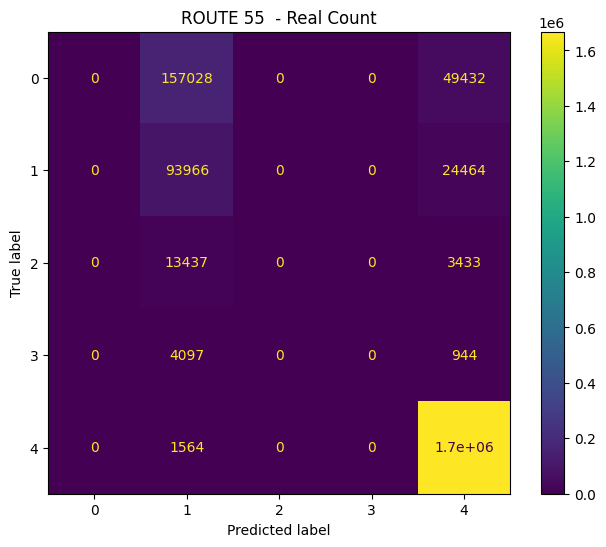

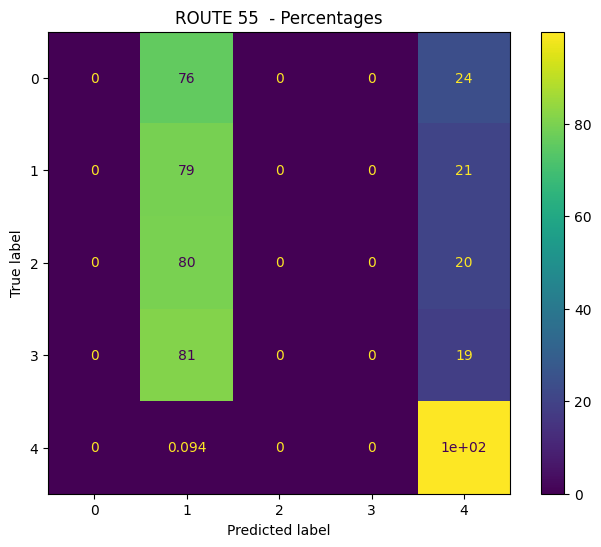

In [ ]:
test_acc_w_4th = get_CM(temp.ytrue,temp.ypred,'ROUTE 55 ','with 4th bin',curr_experiment_path)
history['test_acc_with_4th_bin'] = test_acc_w_4th


Accuracy without 4th bin: 0.27095077580514476


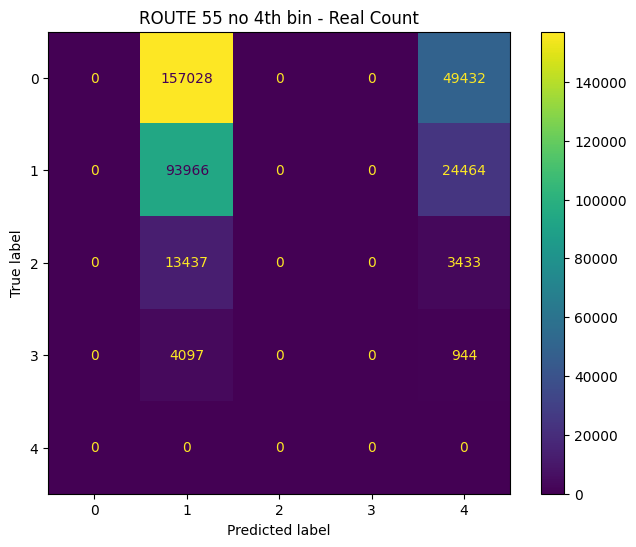

/tmp/ipykernel_3699319/3896929935.py:17: RuntimeWarning: invalid value encountered in divide
  cm = ((cm * 100) / (cm.sum(axis=1)[:, np.newaxis]))


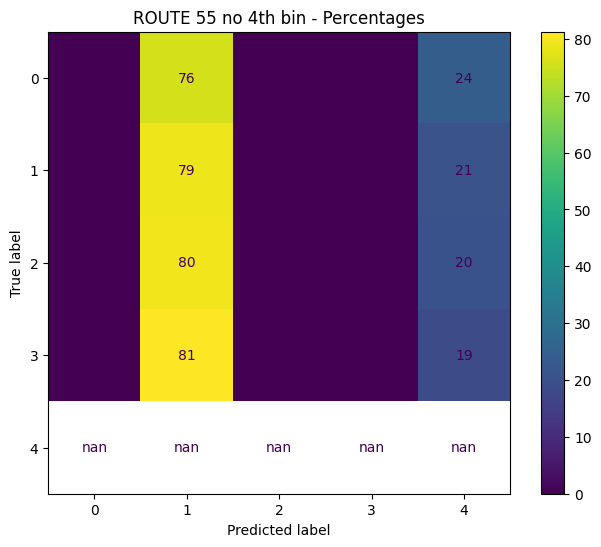

In [ ]:
temp2 = temp
temp2 = temp2[temp2.ytrue != 4]
temp2.reset_index(drop=True,inplace=True)
test_acc_w_o_4th = get_CM(temp2.ytrue,temp2.ypred,'ROUTE 55 no 4th bin','without 4th bin',curr_experiment_path)
history['test_acc_without_4th_bin'] = test_acc_w_o_4th

In [ ]:
def accuracy_metric(y_true,y_pred):
        a = []
        
        for i in range(len(y_true)):
            yt = y_true[i]
            yp = y_pred[i]

            temp = 1 - (np.abs(yt-yp)/num_classes)
            a.append(temp)
        # print(a)
        accuracy = sum(a)/len(y_true)

        return accuracy

custom_accuracy = accuracy_metric(temp2.ytrue,temp2.ypred)
print('Custom Accuracy Metric:',custom_accuracy)
history['custom_accuracy'] = custom_accuracy

Custom Accuracy Metric: 0.7361086040679538


In [ ]:
print(history)

{'epoch': [1, 2],
 'train_acc': [0.014857068494339131, 0.06876295092579307],
 'validation_acc': [0.06849488412451643, 0.2761488123214867],
 'train_loss': [5.253599166870117, 5.379883289337158],
 'validation_loss': [5.525747776031494, 5.440337657928467],
 'test_acc_with_4th_bin': 0.8738031967006152,
 'test_acc_without_4th_bin': 0.27095077580514476,
 'custom_accuracy': 0.7361086040679538}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(temp.ytrue,temp.ypred, average='weighted')

In [ ]:
history_df = pd.DataFrame(history)
history_df.to_csv(f'{curr_experiment_path}/history_w_results.csv')

In [ ]:
# Open a file in write mode ('w' or 'a' for append)
with open('./results/sn_de_1_hr/static_node_dynamic_edge_1_hr_output.txt', 'w') as file:
    # Write data to the file
    file.write(f"The precision, recall and f1-score are: {precision}, {recall} and {f1_score}")
    file.write(f'Custom Accuracy Metric: {custom_accuracy}')

In [ ]:
temp.to_csv('./results/sn_de_1_hr/static_node_dynamic_edge_1_hr_preds.csv')